# Computing 2D Convex Hulls with Python

A [convex hull](https://medium.com/@pascal.sommer.ch/a-gentle-introduction-to-the-convex-hull-problem-62dfcabee90c)
is a polygon which is the smallest convex polygon on the 2D plane, that encloses all of the points in a point cloud $P_n = \left\{ \vec{p_i} \;\big|\; i=1 \dots n \wedge \vec{p_i} \in \mathbb{R}^2 \right\}$. As described in [Introduction to Convex Hull Applications](http://www.montefiore.ulg.ac.be/~briquet/algo3-chull-20070206.pdf), convex hulls are used in a variety of application domains.

![Convex Hull](https://ds055uzetaobb.cloudfront.net/uploads/tantSbEgDe-ch2.gif)

This notebook explores:
* an implementation of the [QuickHull](https://en.wikipedia.org/wiki/Quickhull) subdivision algorithm for computing convex hulls of point clouds
* a marching algorithm to add points to existing convex hulls one by one.

**Note**: For production code it is recommended to use
[scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html) 
from the [scipy](https://www.scipy.org/) package.

## About this Jupyter Notebook

This _Gist_ was created using:
* the [Jupyter Lab](https://jupyter.org/) computational notebook.
* the _python3_ kernel

Though Python is not best language to implement computational intensive algorithms, it can
_describe_ algorithms in a simple, conceptual way. We also take advantage of the Python
package ecosystem and make extensive use of:
* [matplotlib](https://matplotlib.org/) - to illustrate bits and pieces of the algorithm.
* [numpy](https://numpy.org/) - for vector algebra.
* [typing](https://docs.python.org/3/library/typing.html) - to add type hints to methods as function
  in order to convey semantics and usage.

# Some Utitlities and Environment Setup

In this section we create a few general purpose utilities, so that we do not
need to clutter the algorithms with distracting details.

In [1]:
import collections as cl
import numpy as np
import numpy.linalg as npl
import matplotlib
import matplotlib.pyplot as plt
import functools
from typing import Callable, NewType, Iterable, Tuple
%matplotlib inline

Measuring performance

In [2]:
def callcounted(fnc : Callable) -> Callable:
    '''Decorator to count the number of method calls.'''
    @functools.wraps(fnc)
    def _callcounter (self,*args,**kwargs):
        _callcounter.callcount +=1
        return fnc(self,*args,**kwargs)
    _callcounter.callcount = 0
    return _callcounter

Drawing tools

In [3]:
def draw_polygon(ax,points: Iterable[np.ndarray]):
    '''Draw a polygon with direction arrows.'''
    s = points[0]
    points.append(s) # close the loop
    for p in points[1:]:
        ax.arrow(s[0],s[1],p[0]-s[0],p[1]-s[1],
                 length_includes_head=True,head_width= 0.05, head_length=0.1, capstyle='projecting')
        s = p
    ax.scatter([pt[0] for pt in points],[pt[1] for pt in points])

In [4]:
def make_coordinate_system(subplots: int = 1, dx = (-10,130), dy = (-10,110)):
    '''Set up a figure in a canonocal way.'''
    plts = plt.subplots(1,subplots,sharey=True)

    if subplots == 1:
        axs = (plts[1],)
    else:
        axs = plts[1]
    for ax in axs:
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xlabel('x')
        ax.set_xlim(dx)
        ax.set_ylim(dy)

    axs[0].set_ylabel('y')
    return plts

# Points on the 2-d Plane

To represent 2-dimensional points in a point cloud we are going to use numpy arrays.
This way we do not have to take care of the details of vector algebra.

With this the point $\vec{p} = \begin{bmatrix} 1 \\ 2 \end{bmatrix} $
is represented as:

In [5]:
p = np.array([1,2])

Drawing this point on the 2d plane

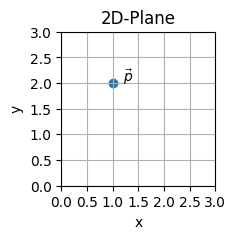

In [6]:
fig,ax = make_coordinate_system(1,dx = (0,3), dy = (0,3))
fig.set_size_inches(2, 2, forward=True)
ax.scatter([p[0]], [p[1]])
ax.set_xticks(np.linspace(0,3,num=7))
ax.set_yticks(np.linspace(0,3,num=7))
ax.set_title('2D-Plane')
ax.annotate('$\\vec{p}$', xy=p, xytext=(15,1), ha='right', textcoords='offset points')
None

# 2-D Polygons

As basis for representing a convex hull we start with a
[polygon](https://en.wikipedia.org/wiki/Polygon).
A polygon is a plane figure that is described by a finite number of straight line segments connected to form a closed polygonal chain or polygonal loop. We note that a convex hull
is a _special_ polygon where all edges have convex angles. For convenience we orient the edges (straight line segments) of a polygon so that they loop counter-clockwise around the interior of the polygon. The orientation
conventions helps us to easily classify point as inside (to the left of all edges of a convex polygon)
or outside (to the right of all edges of a convex polygon).

## PolygonEdge Class

The edges of a polygon are oriented straight line segments bounded by a start and end vertex.

In the convext of convex hull calculations we will mainly focus on edges $e(\vec{a},\vec{b})$ 
defined on points from the point cloud $P_n$:

$$
e(\vec{a},\vec{b}) = \left\{ \vec{a},\vec{b} \;\big|\;
\vec{a},\vec{b} \in P_n  \wedge \vec{a} \neq \vec{b} \right\}
$$
 
Points have signed distances when measured against an the (infinite) straight line on which the
oriented edge is defined. Points to the right of an oriented edge have positive distances,
points to the left have negative distances.

In [7]:
class PolygonEdge:
    '''A edge which is part of a closed, counter-clockwise loop of edges (polygon).'''
    def __init__(self,start_pt: np.ndarray, end_pt: np.ndarray,
                 next : 'PolygonEdge' = None, previous: 'PolygonEdge' = None):
        self.start = start_pt
        delta = end_pt-start_pt
        # difference vector to end point.
        # end = start + delta
        self.delta = delta
        norm = npl.norm(delta)
        if norm > 0:
            self.direction = delta / norm
        else:
            self.direction = None

        self.next = next
        if next:
            next.previous = self

        self.previous = previous
        if previous:
            previous.next = self

    @property
    def end(self):
        '''Get the end vertex of the edge.'''
        if self.next:
            # next edge's start
            return self.next.start
        else:
            # compute it if edge is not part of a polygon
            return self.start + self.delta

    def draw(self, ax: matplotlib.axes.Axes, head_size : float = 0.1,
             color = 'black') -> None:
        '''Draw edge.'''
        end = self.end
        ax.arrow(self.start[0],self.start[1],self.delta[0],self.delta[1],
                 length_includes_head=True,head_width = head_size / 2, head_length=head_size,
                 color=color)

    @callcounted
    def distance(self,pt: np.ndarray) -> float:
        ''' Signed distance of a point to the (unbounded) straight line
            of this edge.
                    + x
                    /│
                   / │ d = (x-s) x dir
                  /  │
                 /   │
                +----.--->--+ <- edge
                s    x'     e
            Points to the right have positive distances, points to the left
            have negative distances.
        '''
        return np.cross(pt-self.start,self.direction)

Creating a sample polygon edge named $edge$ bounded by the two vertices $\vec{p_1}$ and  $\vec{p_2}$.

In [8]:
p1 = np.array([1,1])
p2 = np.array([2,3])
edge = PolygonEdge(p1,p2)

Drawing this polygon edge with explanatory annotations.

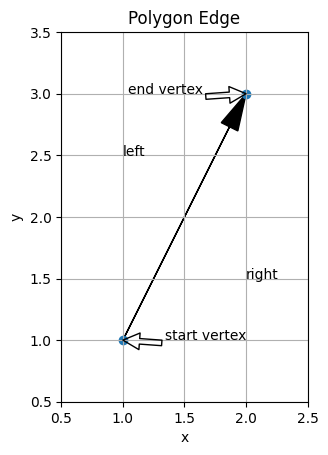

In [9]:
fig,ax = make_coordinate_system(1,dx=(0.5,2.5),dy=(0.5,3.5))
edge.draw(ax,0.3)
ax.scatter([p1[0],p2[0]],[p1[1],p2[1]])
ax.annotate('left',(1,2.5))
ax.annotate('right',(2,1.5))
ax.annotate('start vertex',p1, xytext = (30,0),
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')
ax.annotate('end vertex',p2, xytext = (-85,0),
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')
ax.set_title('Polygon Edge')
None

## Polygon Class

To work with a closed loop of oriented polygon edges we define a class
representing a set of connected edges.

$$
PG_m(P_n) = \left\{ e_j(\vec{a_j},\vec{b_j}) \;\big|\;
j = 1 \dots m
\wedge
\vec{b_{j}} = \vec{a_{j+1}}
\wedge
\vec{b_{m}} = \vec{a_{1}}
\right\}
$$

where $PG_m(P_n)$ represents a polygon with $m$ edges defined on points of the point cloud $P_n$.

We will use this class to:
* create a polygon from an ordered set of points.
* Iterate over the vertices or edges of the polygon
* draw the polygon

In [10]:
class Polygon:
    def __init__(self, points: Iterable[np.ndarray] = None):
        '''Construct a polygon from an ordered lis of points.'''
        if not points: return

        point_itr = iter(points)

        start_pt = next(point_itr)
        end_pt   = next(point_itr)
        loop_start = PolygonEdge(start_pt, end_pt)
        start_pt = end_pt
        previous = loop_start
        # process remaining points
        for p in point_itr:
            previous = PolygonEdge(start_pt, p, next = loop_start, previous = previous)
            start_pt = p

        PolygonEdge(start_pt,loop_start.start,next = loop_start,previous=previous)
        self.loop_start = loop_start

    @property
    def vertices(self) -> Iterable[np.ndarray]:
        '''Generator to iterate over all vertices of the polygon.'''
        for edge in self.edges:
            yield edge.start

    @property
    def edges(self) -> Iterable[PolygonEdge]:
        '''Generator to iterate over all edges of the polygon.'''
        edge = self.loop_start
        loop_end = edge.previous
        while not edge is loop_end:
            yield edge
            edge=edge.next
        yield loop_end

    def draw(self,ax: matplotlib.axes.Axes, head_size : float = 0.1) -> None:
        '''Draw the polygon to a subplot.'''
        for edge in self.edges:
            edge.draw(ax,head_size)

We can now create a polygon from a counter clockwise sequence of vertices like so:

In [11]:
polygon = Polygon([np.array([1,1]), np.array([2.5,1.5]),  np.array([3,2]),
                   np.array([2,2]), np.array([1.75,1.6]), np.array([1.25,1.8])])

This polygon can easily be drawn using its `draw` method:

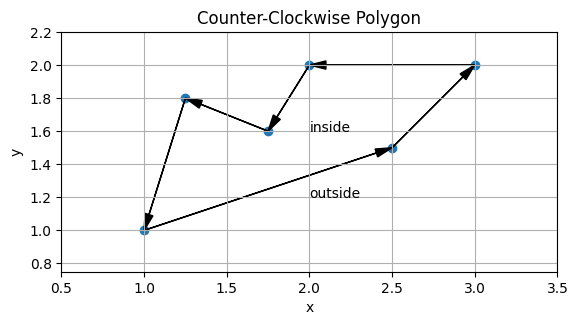

In [12]:
fig,ax = make_coordinate_system(1,dx=(0.5,3.5),dy=(0.75,2.2))

ax.scatter([p[0] for p in polygon.vertices],[p[1] for p in polygon.vertices])
ax.annotate('inside',(2,1.6))
ax.annotate('outside',(2,1.2))
ax.set_title('Counter-Clockwise Polygon')
polygon.draw(ax)

# 2D Convex Hulls from a Point Cloud
A [convex hull](https://medium.com/@pascal.sommer.ch/a-gentle-introduction-to-the-convex-hull-problem-62dfcabee90c)
is the smallest convex polygon, that encloses all of the points in a point cloud.
We build a convex hull from an unordered point cloud by using a subdivision technique known as [QuickHull](https://en.wikipedia.org/wiki/Quickhull). The Quickhull performance characteristic is
known to be $O(n \cdot log(n))$

## OuterSector Class

Computation of a convex hull requires some means to determine whether points are outside or inside of a
convex hull. We already have a way to determine if point is left or right to the (unbounded) straight
line of a edge by calculating its signed distance. With this we can subdivide a point cloud using
the signed distance method of edges.

We define a class which describes the subset of points $OS(e)$ with $OS(e) \subset P_n$  where
all points of $OS(e)$ are to the right of the polygon edge $e(\vec{a},\vec{b},)$:

$$
OS(e) = \left\{ \vec{p} \;\big|\;
\vec{p} \in P_n
\wedge
dist(e,\vec{p}) > 0
\right\}
$$

where $e$ is a shorthand notation for the edge $e(\vec{a},\vec{b})$.

With this, a convex hull $C_m(P_n)$ of the point cloud $P_n$ can be described as a
polygon $PG_m(P_n)$ where there are no points of $P_n$ outside (to the _right_) of any of its edges:

$$
C_m(P_n) = PG_m(P_n) \Longleftrightarrow  \forall e \in PG_m(P_n) \;\big|\; OS(e) = \emptyset
$$

We define a utility class (`OuterSector`) which represents the set $OS(e)$
and use this class to iteratively build a polygon until $OS(e) = \emptyset$
for all edges of that polygon.

The `OuterSector` implementation shall be able to:
* classify points in a point cloud as _right_ or _left_ relative to an oriented section line
  (represented by a `PolygonEdge` instance).
* compute the outermost point (apogee) for _right_ (outside) points. An apogee, by definition,
  is a point on the convex hull.
* subdivide its defining edge.

In [13]:
class OuterSector:
    def __init__(self,section_line: PolygonEdge):
        '''Use a polygon edge to define a sector.'''
        self.section_line = section_line
        self.outer_points = cl.deque()
        self.apogee = None
        self._peak_distance = -1

    def add_points(self, points: Iterable[np.ndarray]) -> Iterable[np.ndarray]:
        '''Add points to the sector. Outer points are recorded, Inner points are
           returned as a point collection.'''
        inner_points = cl.deque()
        point_itr = iter(points)
        for p in point_itr:
            dist = self.section_line.distance(p)
            if dist > 0:
                if dist > self._peak_distance:
                    if not self.apogee is None:
                        # put ols apogee back into the pool
                        self.outer_points.append(self.apogee)
                    self.apogee = p
                    self._peak_distance = dist
                else:
                    self.outer_points.append(p)
            else:
                # point on the section line or inside
                # (left to the section line)
                inner_points.append(p)
        return inner_points

    def subdivide(self) -> Tuple['OuterSector','OuterSector']:
        '''Subdivide into 2 section lines joined at the apogee'''
        if not self.apogee is None:
            section_line1 = PolygonEdge(self.section_line.start,self.apogee,
                                        previous = self.section_line.previous)
            sector1 = OuterSector(section_line1)
            remaining_points = sector1.add_points(self.outer_points)
            section_line2 = PolygonEdge(self.apogee,self.section_line.end,
                                        next = self.section_line.next,
                                        previous = section_line1)

            sector2 = OuterSector(section_line2)
            sector2.add_points(remaining_points)
            return (sector1, sector2)

    def draw(self,ax: matplotlib.axes.Axes, head_size : float = 0.1) -> None:
        '''Draw the sector'''
        ax.scatter([p[0] for p in self.outer_points],[p[1] for p in self.outer_points], color='blue')
        # draw start and endpoints
        start = self.section_line.start
        end = self.section_line.end
        ax.scatter([start[0],end[0]],[start[1],end[1]],color='blue')
        if not self.apogee is None:
            ax.scatter([self.apogee[0]],[self.apogee[1]], marker = 'X',  s=120, c = 'red')
        self.section_line.draw(ax,head_size)

Now let's experiment with this class on a randomly created point cloud.

In [14]:
n=33 # point cloud size
point_cloud=[np.random.random(2)*100 for _ in range(n)] # n random points

Next we create an edge with can serve as a section line for now (thoug its vertices are not from the point
cloud $P_n$). We pick start and end vertex so that the
edge somewhat bisects the point cloud.

In [15]:
section_line = PolygonEdge(np.array([0,0]),np.array([100,100]))

Finally we can construct a sector from that section line and the sample point cloud.

In [16]:
sector = OuterSector(section_line)
inner_points = sector.add_points(point_cloud)

In the figure below we see how the `OuterSector` instance subdivided the point cloud.

Points to the right of the section line are represented as blue dots. These points are _recorded_
by the `OuterSector` instance.  They are also are used to compute the _apogee_.

Green dots represent left points which are **not** recorded in this instance `OuterSector`.

We note that:
* the apogee is also a vertex on the convex hull (if it exists).
* if an _OuterSector_ instance contains no _right_ points, it is an edge of the convex hull,
  provided its end vertices are also vertices of the convex hull polygon. 

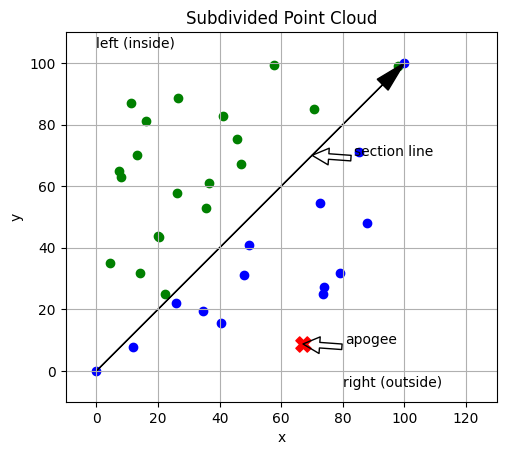

In [17]:
fig,ax = make_coordinate_system()

ax.scatter([p[0] for p in inner_points],[p[1] for p in inner_points], color='green')

sector.draw(ax,10)

ax.annotate('apogee',sector.apogee,
            xytext = (30,0),
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')
ax.annotate('left (inside)',(0,105))
ax.annotate('right (outside)',(80,-5))
ax.set_title("Subdivided Point Cloud")

ax.annotate('section line', (70,70),
            xytext = (30,0),
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')
None

Using this we can demonstrate the effect of a sector subdivision where this `OuterSector`
instance is subdivided at its apogee. For comparison we create a new sector with the same
specs as before which we then subdivide.

In [18]:
sector2 = OuterSector(PolygonEdge(np.array([0,0]),np.array([100,100])))
inner_points2 = sector2.add_points(point_cloud)
subsectors = sector2.subdivide()

To illustrate the subdivision effect we draw the original sector and the subdivided sector
side-by-side:

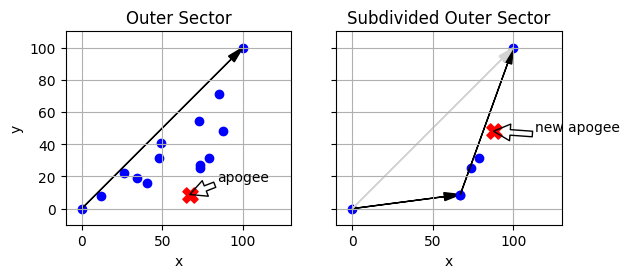

In [19]:
fig,ax = make_coordinate_system(2, dx=(-10,130), dy=(-10,110)) # make 2 subplots

# draw the original sector
sector.draw(ax[0],10)
ax[0].set_title('Outer Sector')
ax[0].annotate('apogee',sector.apogee,
            xytext = (20,10),
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')

# draw the subdivision result
subsectors[0].draw(ax[1],10)
subsectors[1].draw(ax[1],10)

if not subsectors[0].apogee is None:
    ax[1].annotate('new apogee',subsectors[0].apogee,
                   xytext = (30,-10),
                   arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
                   textcoords ='offset points')
if not subsectors[1].apogee is None:
    ax[1].annotate('new apogee',subsectors[1].apogee,
                   xytext = (30,0),
                   arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
                   textcoords ='offset points')
# draw the original section line
sector.section_line.draw(ax[1],10,color='lightgray')
ax[1].set_title('Subdivided Outer Sector')
None

We see that the subdivision created 2 new edges which _enclose_ more points of the point cloud.

We also note that if we create an intial set of `OuterSector`
instances so that:
* the section lines represent a convex, counter-clockwise polygon
* the end-points of all section lines are points of the convex

then we can then keep subdividing the sectors until all vertices of the convex hull are found.
Since there is only a finite number of vertices in the convex hull, therefore
the subdivision process will eventually end.

Once subdivision has ended the underlying polygon is the convex hull.

## Finding an Intial Convex Polygon

For the iterative sector subdivision to yield the convex hull we must seed it with a convex polygon
whose end vertices are already vertices of the convex hull. Fortunately, we can compute a good initial
section line by searching for two distinct points which the smallest/highest x or y coordinates.

In [20]:
def compute_section_line(point_cloud : Iterable[np.array]) -> PolygonEdge:
    '''Find a good section line for a point clpud.'''
    point_itr = iter(point_cloud)
    x_min_pt = x_max_pt = y_min_pt = y_max_pt = next(point_itr)
    x_min = x_max = x_min_pt[0]
    y_min = y_max = y_min_pt[1]

    for p in point_itr:
        x,y = p
        if x < x_min:
            x_min_pt = p
            x_min  = x
        elif x > x_max:
            x_max_pt = p
            x_max = x

        if y < y_min:
            y_min_pt = p
            y_min  = y
        elif y > y_max:
            y_max_pt = p
            y_max = y

    if (x_max - x_min) > (y_max - y_min):
        return PolygonEdge(x_min_pt,x_max_pt)
    else:
        return PolygonEdge(y_min_pt,y_max_pt)

Let's visualize this with the sample point cloud we have been using so far:

In [21]:
good_section_line = compute_section_line(point_cloud)

this looks like so:

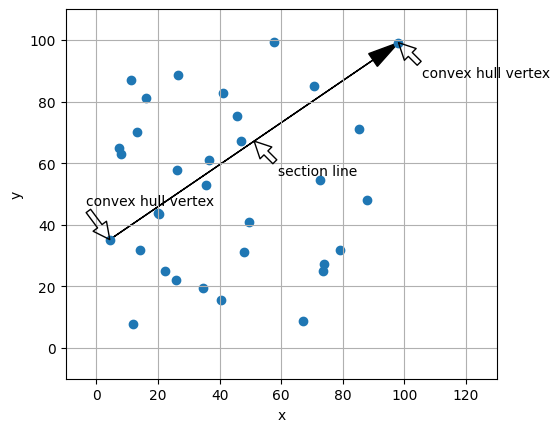

In [22]:
fig,ax = make_coordinate_system()

textoffset = np.array([good_section_line.direction[1],-good_section_line.direction[0]])*30
ax.annotate('section line', (good_section_line.start + good_section_line.end)/2,
            xytext = textoffset,
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')
ax.annotate('convex hull vertex',good_section_line.start,
               xytext = -textoffset,
               arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
               textcoords ='offset points')
ax.annotate('convex hull vertex',good_section_line.end,
               xytext = textoffset,
               arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
               textcoords ='offset points')
good_section_line.draw(ax,10)
ax.scatter([p[0] for p in point_cloud],[p[1] for p in point_cloud])

## Assembling the QuickHull Algorithm

Finally we have all the pieces to (slowly) walk through the [QuickHull](https://en.wikipedia.org/wiki/Quickhull) subdivision algorithm.

Using the sample point cloud from above and the `good_section_line` we have already calculated we
define an initial convex polygon by adding a _reverse_ edge to create a _closed_ edge loop. This
produces a degenerate but convex polygon.

In [23]:
seed_polygon = Polygon([good_section_line.start, good_section_line.end, good_section_line.start])

This seed polygon looks like so:

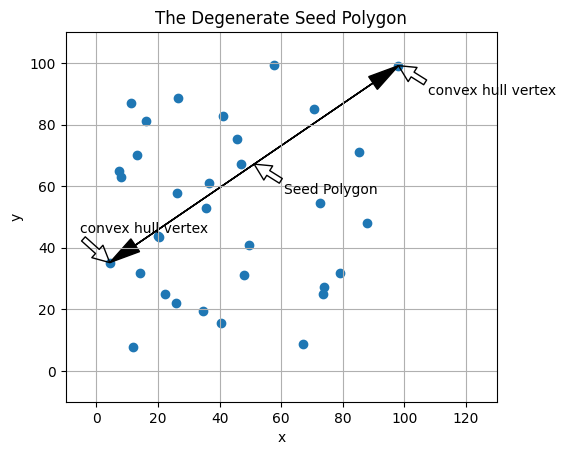

In [24]:
fig,ax = make_coordinate_system()

ax.scatter([p[0] for p in point_cloud],[p[1] for p in point_cloud])
textoffset = np.array([section_line.direction[1],-section_line.direction[0]])*30
seed_polygon.draw(ax,10)
ax.annotate('Seed Polygon', (seed_polygon.loop_start.start + seed_polygon.loop_start.end)/2,
            xytext = textoffset,
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')
ax.annotate('convex hull vertex',seed_polygon.loop_start.start,
               xytext = -textoffset,
               arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
               textcoords ='offset points')
ax.annotate('convex hull vertex',seed_polygon.loop_start.end,
               xytext = textoffset,
               arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
               textcoords ='offset points')
ax.set_title("The Degenerate Seed Polygon")
None

To prepare for iterative subdivision of the convex seed polygon we set up a stack of
`OuterSector` instances for keeping track of the sectors we still need to work on.

In [25]:
subdivision_stack = cl.deque()

Now we create a sector to the first edge of the seed polygon and push it onto the stack. 

In [26]:
sector1 = OuterSector(seed_polygon.loop_start)
remaining_points = sector1.add_points(point_cloud)
subdivision_stack.append(sector1)

With the points which were _rejected_ by the first sector's `add_points` and remembered in `remaining_points`
we construct the second sector and push it onto the stack. `remaining_points` contains the point which
are left (inside) the first sector. This set of points is ideally significantly smaller than the original
point cloud.

In [27]:
sector2 = OuterSector(seed_polygon.loop_start.next)
sector2.add_points(remaining_points)
subdivision_stack.append(sector2)

Now the subdivision process can start. Ideally we do this until the stack is empty.
However, for illustration purposes we do this only $m$ times.

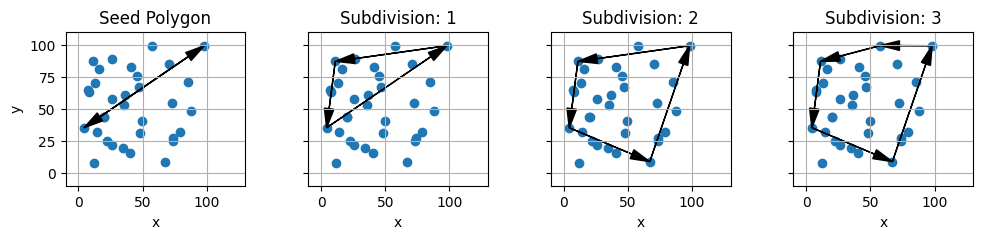

In [28]:
m=3
fig,ax = make_coordinate_system(m+1)
fig.set_size_inches(12, 2, forward=True)

ax[0].scatter([p[0] for p in point_cloud],[p[1] for p in point_cloud])
ax[0].set_title('Seed Polygon')
seed_polygon.draw(ax[0],15)

subdivision_count = 1
while len(subdivision_stack)> 0 and subdivision_count < (m+1):
    sector = subdivision_stack.pop()
    if sector.apogee is None:
        seed_polygon.loop_start = sector.section_line
    else:
        sector1,sector2 = sector.subdivide()
        seed_polygon.loop_start = sector1.section_line

        subdivision_stack.appendleft(sector1)
        subdivision_stack.appendleft(sector2)

        ax[subdivision_count].scatter([p[0] for p in point_cloud],[p[1] for p in point_cloud])
        ax[subdivision_count].set_title( f'Subdivision: %d' % subdivision_count)

        seed_polygon.draw(ax[subdivision_count],15)
        subdivision_count += 1

## ConvexHull Class

Finally we can wrap the bits and pieces of the [QuickHull](https://en.wikipedia.org/wiki/Quickhull)
algorithm into the `ConvexHull` class.

This class now just needs to _orchestrate_ the steps developed earlier.

In [29]:
class ConvexHull (Polygon):

    def __init__(self):
        '''Construct an empty polygon'''
        self.loop_start = None

    def add_points(self, points : Iterable[np.ndarray]) -> None:
        '''Expand the concex hull based on the given points.'''
        # if we already have a convex hull add its
        # vertices to the given point cloud
        if self.loop_start:
            point_cloud = cl.deque(self.vertices)
            point_cloud.extend(points)
        else:
            point_cloud = points

        # Create a processing stack for sectors to subdivide.
        subdivision_stack = cl.deque()

        # Find a good initial section line.
        section_line = compute_section_line(point_cloud)
        self.loop_start = section_line

        # create a closed, degenerate convex polygon
        reverse_section_line = PolygonEdge(section_line.end,section_line.start,
                                           next = section_line, previous = section_line)

        # Enroll sectors of the seed polygon for processing
        for edge in self.edges:
            sector = OuterSector(edge)
            point_cloud = sector.add_points(point_cloud)
            subdivision_stack.append(sector)

        # run the subdivision process until we have a convex hull
        while len(subdivision_stack) > 0:
            sector = subdivision_stack.pop()
            if sector.apogee is None:
                self.loop_start = sector.section_line
            else:
                sector1,sector2 = sector.subdivide()
                subdivision_stack.appendleft(sector1)
                subdivision_stack.appendleft(sector2)

For experimentation we set up two disjoint point clouds with $n$ points each.

In [30]:
n=99
point_cloud1 = [np.random.random(2)*50 for _ in range(n)]
point_cloud2 = [np.random.random(2)*50 + 50 for _ in range(n)]

Now we add both point clouds to an empty convex hull. We also reset the counter for the `distance`
method of the `PolygonEdge`. Knowing the number of point-to-edge distance calculations should provide some
rough metric of the performance of this algorithm.

In [31]:
hull = ConvexHull() # empty hull

PolygonEdge.distance.callcount=0 # reset performace counter
hull.add_points(point_cloud1)
hull.add_points(point_cloud2)

Let's visualize the result and print out the performance metric. Note that the two point clouds
are drawn with different colors.

198 points required 840 distance calculations


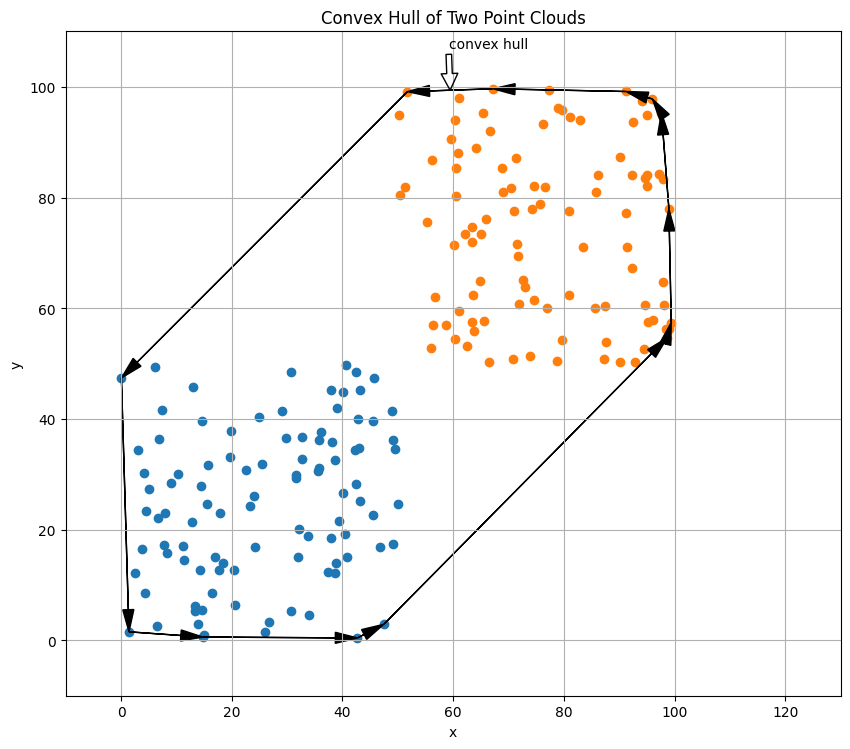

In [32]:
fig,ax = make_coordinate_system()
fig.set_size_inches(10, 10, forward=True)

ax.scatter([p[0] for p in point_cloud1],[p[1] for p in point_cloud1])
ax.scatter([p[0] for p in point_cloud2],[p[1] for p in point_cloud2])
ax.set_title('Convex Hull of Two Point Clouds')
hull.draw(ax,4)

textoffset = np.array([hull.loop_start.direction[1],-hull.loop_start.direction[0]])*30
ax.annotate('convex hull', (hull.loop_start.start + hull.loop_start.end)/2,
            xytext = textoffset,
            arrowprops=dict( fc = 'None', ec='black', shrink=1.5),
            textcoords ='offset points')

print (len(point_cloud1) + len(point_cloud2),
       'points required', PolygonEdge.distance.callcount, 'distance calculations')

## Adding Points to a Convex Hull One by One

The implementation of the `ConvexHull` class already allows for adding more than one point cloud
to an existing convex hull. However, if points need to be added to an existing point cloud
**individually**, the [QuickHull](https://en.wikipedia.org/wiki/Quickhull) subdivision approach
is a big hammer for a small job. For single points we choose marching algorithm to add
points one by one which has $O(m)$ complexity with $m$ being the number of edges in the convex hull).

To illustrate how the marching algoritm works we use the small cloud of randon point
we create earlier and create a convex hull for it.

In [33]:
hull = ConvexHull()
hull.add_points(point_cloud)

We also need a point that we can add to the convex hull. We choose a point which is outside
the convex hulls so that we get some action. Attempting to add a point which is **inside** the
convex hull does not change the hull.

In [34]:
p = np.array([110,50]) # make sure it is outside the convex hull

Now we start _marching_ around the polygon to determine the sequence of edges where the point is
classified as _outside_ (distance is positive).

In [35]:
polyline_start = polyline_end = None

for i,edge in enumerate(hull.edges):
    if edge.distance(p) > 0:
        if polyline_end:
            polyline_end = edge
        else: # first edge whre point is outside
            polyline_start = polyline_end = edge
            if i == 0:
                # expand polyline backwards
                probe = edge.previous
                while not probe is edge:
                    if probe.distance(p) > 0:
                        polyline_start = probe
                        probe = probe.previous
                    else:
                        break
    elif polyline_end: # point is outside the convex hull
        # we can stop here because we have a contiguous
        # set of edges (polyline) starting at
        # 'polyline_start' and ending at 'polyline_end'
        break

The sequence of edges we found (if any) indicate the place where the convex hull needs
to be extended to include the given point.

In [36]:
if polyline_end:
    edge1 = PolygonEdge(polyline_start.start,p,
                        previous = polyline_start.previous)
    PolygonEdge(p,polyline_end.end,
                next = polyline_end.next, previous = edge1)
    hull.loop_start = edge1

Let's draw this the 2 stages of adding the point.

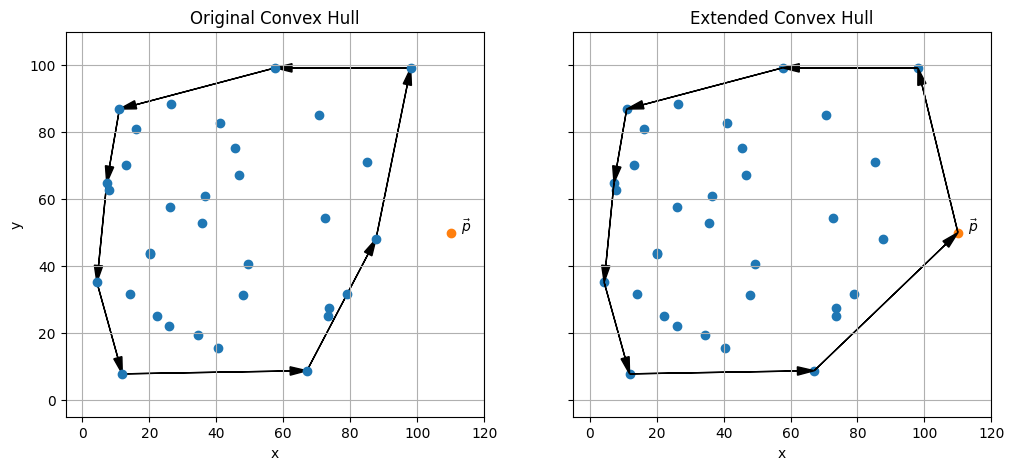

In [37]:
fig,ax = make_coordinate_system(2, dx=(-5,120), dy=(-5,110))
fig.set_size_inches(12, 5, forward=True)

# draw original convex hull
hull_orig = ConvexHull()
hull_orig.add_points(point_cloud)
hull_orig.draw(ax[0],5)

ax[0].scatter([p[0] for p in point_cloud],[p[1] for p in point_cloud])
ax[0].scatter([p[0]],[p[1]])
ax[0].annotate('$\\vec{p}$', xy=p, xytext=(15,1), ha='right', textcoords='offset points')
ax[0].set_title('Original Convex Hull')

# draw extend hull
ax[1].scatter([p[0] for p in point_cloud],[p[1] for p in point_cloud])
ax[1].scatter([p[0]],[p[1]])
hull.draw(ax[1],5)
ax[1].annotate('$\\vec{p}$', xy=p, xytext=(15,1), ha='right', textcoords='offset points')
ax[1].set_title('Extended Convex Hull')
None

## class ConvexHullEx - Extended Convex Hull

Having the marching algorithm is layed out as well, we can wrap everthing up
into a multi-purpose convex hull class.

In [38]:
class ConvexHullEx (ConvexHull):
    def __init__(self):
        super().__init__()

    def add_point(self, point : np.array) -> None:
        if self.loop_start:
            if self.loop_start.next is self.loop_start:
                # got a nucleaus
                self.loop_start = PolygonEdge(self.loop_start.start,point)
            else: # got a convex hull
                # march arround the existing convex hull until we find an
                # edge to which the point has a positive distance
                # (meaning the point is outside the convex hull).
                # If we find such an edge, we expand the convex hull to
                # include the point.
                #
                # If the point-to-edge distance of the point is negative for
                # all edges of the convex hull, the point is inside the
                # convex hull and can be discarded.

                polyline_start = polyline_end = None

                for i,edge in enumerate(self.edges):
                    if edge.distance(point) > 0:
                        if polyline_end:
                            polyline_end = edge # just extend the polyline
                        else: # first edge where point is outside
                            polyline_start = polyline_end = edge
                            if i == 0:
                                # expand polyline backwards
                                probe = edge.previous
                                while not probe is edge:
                                    if probe.distance(point) > 0:
                                        polyline_start = probe
                                        probe = probe.previous
                                    else:
                                        break
                    elif polyline_end: # point is outside the convex hull
                        # we can stop here because we have a contiguous
                        # set of edges (polyline) starting at
                        # 'polyline_start' and ending at 'polyline_end'
                        break
                # extend the convex hull
                if polyline_end:
                    edge1 = PolygonEdge(polyline_start.start,point,
                                        previous = polyline_start.previous)
                    PolygonEdge(point, polyline_end.end,
                                next = polyline_end.next, previous = edge1)
                    self.loop_start = edge1
        else:
            # add a nucleus
            self.loop_start=PolygonEdge(point,point)

# Performance Comparison `add_points` vs `add_point`

To assess the performance characteristics of adding points in bulk (`add_points`) versus adding points one-by-one, (`add_point`) we set up two sets of points:
* a point cloud from which we take slices of varying sizes
* a set of points from which we take slices of varying sizes which we are going to add in bulk and
  one-by-one.
  
The make the test scenario more realistic we make it so that both point clouds overlap, so that
some of the points to add will be inside the convex hull of the point cloud.

In [39]:
point_cloud=[np.random.random(2)*75 for _ in range(5000)]
extra_points=[np.random.random(2)*50+50 for _ in range(100)]

The figure below demonstrate the layout of the overlapping point sets.

Text(0.5, 1.0, 'Sample Point Sets')

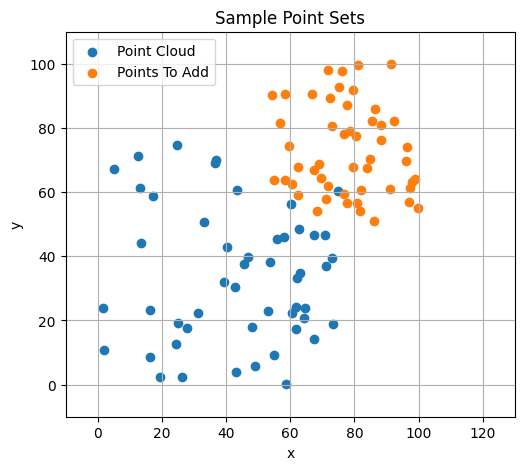

In [40]:
fig,ax = make_coordinate_system(1)
fig.set_size_inches(12, 5, forward=True)
ax.scatter([p[0] for p in point_cloud[0:50]], [p[1] for p in point_cloud[0:50]],label='Point Cloud')
ax.scatter([p[0] for p in extra_points[0:50]], [p[1] for p in extra_points[0:50]],label='Points To Add')
ax.legend()
ax.set_title('Sample Point Sets')

In the intactive graph below the cost (in terms of number of distance calculations) adding points to
an existing convex hull in bulk (`add_points`) versus one-by-one (`add_point`) can be explored.

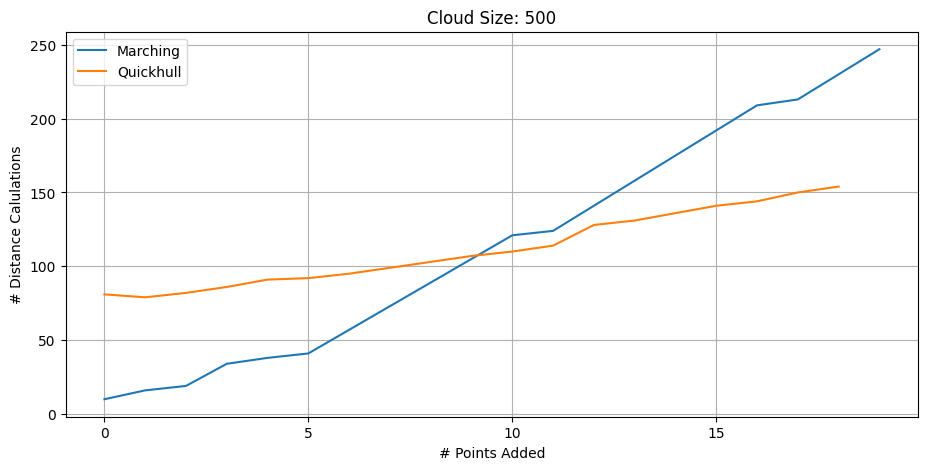

interactive(children=(IntSlider(value=500, continuous_update=False, description='Point Cloud Size', layout=Lay…

<function __main__.draw_costs(cloudsize, addsize)>

In [41]:
from ipywidgets import interact
from ipywidgets import interact_manual
import ipywidgets as ipw

def quickhull_costs(cloud,extra_points):
    for n in range(1,len(extra_points)):
        hull = ConvexHullEx()
        hull.add_points(cloud)

        PolygonEdge.distance.callcount=0
        hull.add_points(extra_points[0:n])
        yield PolygonEdge.distance.callcount

def marching_costs(cloud,extra_points):
    hull = ConvexHullEx()
    hull.add_points(cloud)
    PolygonEdge.distance.callcount=0

    for p in extra_points:
        hull.add_point(p)
        yield PolygonEdge.distance.callcount

def draw_costs(cloudsize,addsize):
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(11,5)
    ax.plot(list(marching_costs(point_cloud[0:cloudsize],extra_points[0:addsize])), label='Marching')
    ax.plot(list(quickhull_costs(point_cloud[0:cloudsize],extra_points[0:addsize])), label='Quickhull')
    ax.legend()
    ax.set_xlabel('# Points Added')
    ax.set_ylabel('# Distance Calulations')
    ax.grid(True)
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.set_title('Cloud Size: %d' % cloudsize)
interact(draw_costs,
         cloudsize=ipw.IntSlider(min         = 1,
                                 max         = len(point_cloud),
                                 step        = 5,
                                 value       = 500,
                                 continuous_update=False,
                                 description = 'Point Cloud Size',
                                 layout      = ipw.Layout(width='80%'),
                                 style       = {'description_width' :'initial'}
                                 ),
        addsize=ipw.IntSlider(min         = 1,
                             max         = len(extra_points),
                             step        = 1,
                             value       = 20,
                             continuous_update=False,
                             description = 'Points to Add',
                             layout      = ipw.Layout(width='80%'),
                             style       = {'description_width' :'initial'}
                             )
        )

## Summary

Experimentation with the sample data shows that the break-even point between adding points in bulk or
one-by-one in terms of number of distance calculations is typically somewhere between 5 and 20 points.
The exact position depends on the distribution of the points in space. For small point sets (< 5) it is most likely
advantageous to add point one-by-one (`add_point`) to an existing convex hull.
Larger point sets should be added in bulk (`add_points`). 

# About this Jupyter Notebook

This Gist was created using the [Jupyter Lab](https://jupyter.org/) computational notebook with
the python3 kernel and following additional Python modules:

In [42]:
from jnbBuffs.manifest import notebook_manifest
notebook_manifest('jupyterlab', 'numpy', 'jnbBuffs', 'matplotlib', 'ipywidgets')

| Component                         | Version                    | Description          |
| --------------------------------- | -------------------------- | -------------------- |
| [Python](https://www.python.org/) | 3.12.0   | Programming Language |
| [ipywidgets](http://jupyter.org) | 8.1.1 | Jupyter interactive widgets |
| [jnbBuffs](https://github.com/WetHat/jupyter-notebooks) | 0.1.10 | Utilities for authoring JupyterLab Python notebooks. |
| [jupyterlab](https://pypi.org/project/jupyterlab/) | 4.0.6 | JupyterLab computational environment |
| [matplotlib](https://matplotlib.org) | 3.8.0 | Python plotting package |
| [numpy](https://numpy.org) | 1.26.0 | Fundamental package for array computing in Python |